<h1>Importing Dependencies</h1>


In [1]:
# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# model training
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaijinu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('Emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
data.shape

(5728, 2)

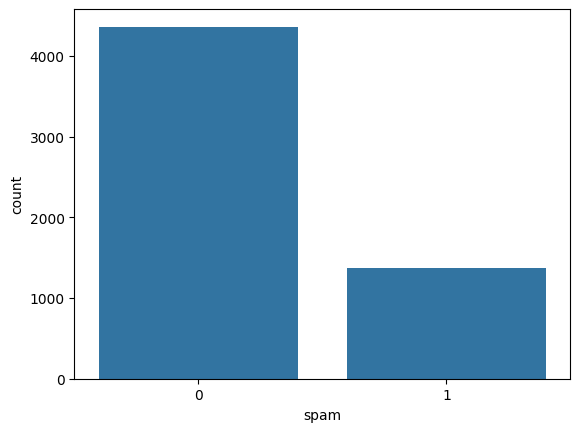

In [4]:
sns.countplot(x='spam', data=data)
plt.show()

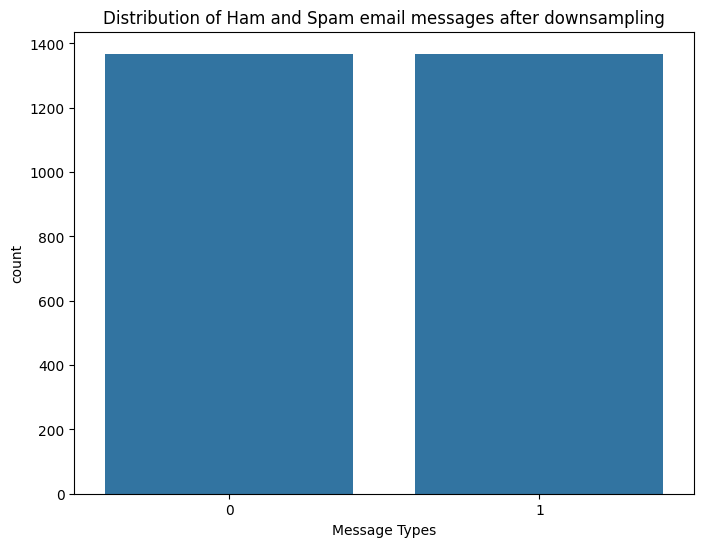

In [12]:
# sampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),random_state=42)

# plotting the counts of sampled dataset
balanced_data = ham_msg._append(spam_msg).reset_index(drop=True)

plt.figure(figsize=(8,6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message Types')
plt.show()

In [13]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [14]:
punctations_list = string.punctuation
def remove_punctations(text):
    temp = str.maketrans('', '', punctations_list)
    return text.translate(temp)

balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctations(x))
balanced_data.head()

,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [18]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    
    imp_words = []
    
    # store important words
    for word in str(text).split():
        word = word.lower()
        
        if word not in stop_words:
            imp_words.append(word)
            
    
    output = " ".join(imp_words)
    
    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


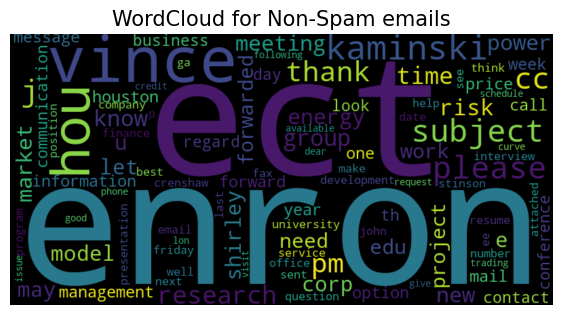

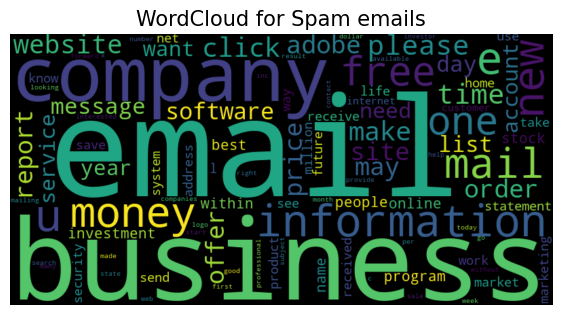

In [19]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    
    plt.figure(figsize=(7,7))
    
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam') 
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')


In [20]:
# training test
X_train, X_text, Y_train, Y_test = train_test_split(balanced_data['text'],balanced_data['spam'], test_size=0.2,random_state=42)

In [21]:
# tokenize train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_text)

# pad sequences to have the same length
max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post',truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post',truncating='post')

In [23]:
# building model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len))


model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           805024    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808737 (3.09 MB)
Trainable params: 808737 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'], optimizer = 'adam')

In [25]:
es = EarlyStopping(patience = 3, monitor = 'val_accuracy', restore_best_weights = True)
lr = ReduceLROnPlateau(patience = 2, monitor = 'val_loss', factor = 0.5, verbose = 0)

In [26]:
# train model
history = model.fit(train_sequences, Y_train, 
                    validation_data = (test_sequences, Y_test),
                    epochs = 20,
                    batch_size = 32,
                    callbacks = [lr,es]
                    )

Epoch 1/20
69/69 [==============================] - 11s 90ms/step - loss: 0.5926 - accuracy: 0.7313 - val_loss: 0.2435 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 5s 78ms/step - loss: 0.1826 - accuracy: 0.9566 - val_loss: 0.1372 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 5s 78ms/step - loss: 0.1385 - accuracy: 0.9671 - val_loss: 0.1206 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 6s 87ms/step - loss: 0.1293 - accuracy: 0.9712 - val_loss: 0.1559 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 5s 78ms/step - loss: 0.1242 - accuracy: 0.9712 - val_loss: 0.1445 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 2s 35ms/step - loss: 0.0905 - accuracy: 0.9817 - val_loss: 0.1283 - val_accuracy: 0.9708 - lr: 5.0000e-04


In [27]:
# evaluating model
test_loss, test_accuracy = model.evaluate(test_sequences, Y_test)
print('Test Loss: ',test_loss)
print('Test Accuracy: ',test_accuracy)

18/18 [==============================] - 0s 8ms/step - loss: 0.1206 - accuracy: 0.9745
Test Loss:  0.12064453214406967
Test Accuracy:  0.974452555179596


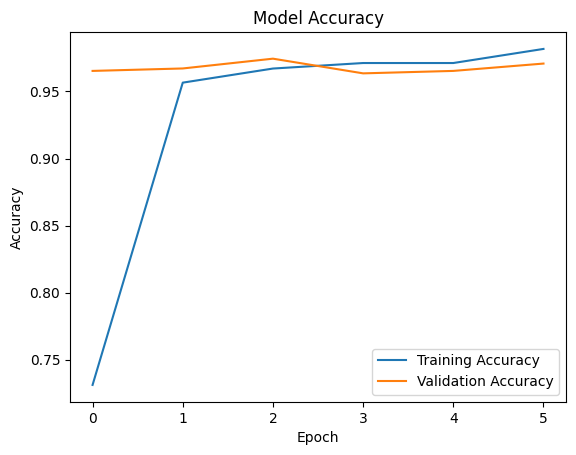

In [28]:
# plot the evaluation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()